# Random Forests and Boosting

These methods use trees as building blocks to build more complex models.
Here we will use the Boston housing data to explore Random Forests and Boosting.
These data are in the `MASS` package.
It gives housing values and other statistics in each of 506 suburbs of Boston
based on a 1970 census.


## Random Forests

Random forests build lots of bushy trees, and then average them to reduce the
variance.


In [1]:
if (!require(randomForest)) {
    install.packages("randomForest")
}
require(MASS)
set.seed(101)


Loading required package: randomForest

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: MASS



In [2]:
dim(Boston)
train <- sample(1:nrow(Boston), 300)
?Boston


[1] 506  14

Boston                  package:MASS                   R Documentation

_H_o_u_s_i_n_g _V_a_l_u_e_s _i_n _S_u_b_u_r_b_s _o_f _B_o_s_t_o_n

_D_e_s_c_r_i_p_t_i_o_n:

     The 'Boston' data frame has 506 rows and 14 columns.

_U_s_a_g_e:

     Boston
     
_F_o_r_m_a_t:

     This data frame contains the following columns:

     'crim' per capita crime rate by town.

     'zn' proportion of residential land zoned for lots over 25,000
          sq.ft.

     'indus' proportion of non-retail business acres per town.

     'chas' Charles River dummy variable (= 1 if tract bounds river; 0
          otherwise).

     'nox' nitrogen oxides concentration (parts per 10 million).

     'rm' average number of rooms per dwelling.

     'age' proportion of owner-occupied units built prior to 1940.

     'dis' weighted mean of distances to five Boston employment
          centres.

     'rad' index of accessibility to radial highways.

     'tax' full

In [3]:
# Lets fit a random forest and see how well it performs. We will use the
# Response `medv`, the median housing value (in \$1k dollars)
rf.boston <- randomForest(medv ~ ., data = Boston, subset = train)
# Very fast. Grew 500 trees. MSR is out of bag MSR - So each observation
# was predicted using the average of trees that didn't include it.
rf.boston



Call:
 randomForest(formula = medv ~ ., data = Boston, subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 12.68651
                    % Var explained: 83.45

The MSR and % variance explained are based on OOB _out-of-bag_ estimates, a
very clever device in random forests to get honest error estimates. The model
reports that `mtry=4`, which is the number of variables randomly chosen at each
split. Since $p=13$ here, we could try all 13 possible valies of `mtry`. We will
do so, record the results, and make a plot.


1  2  3  4  5  6  7  8  9  10  11  12  13  

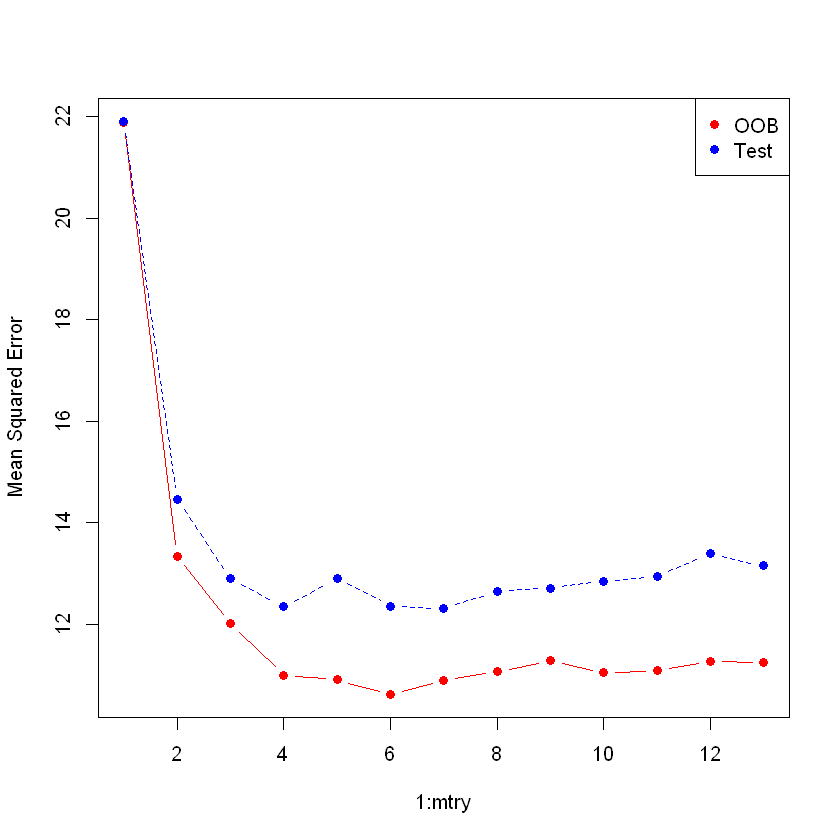

In [8]:
# 13 variables (columns)
num_responses <- ncol(Boston) - 1
oob.error <- double(num_responses)
test.err <- double(num_responses)
for (mtry in 1:num_responses) {
    fit <- randomForest(medv ~ ., data = Boston, subset = train, mtry = mtry, ntree = 400)
    oob.error[mtry] <- fit$mse[400]
    pred <- predict(fit, Boston[-train, ])
    # Compute mean squared error.
    test.err[mtry] <- with(Boston[-train, ], mean((medv - pred)^2))
    cat(mtry, " ")
}
# Plot two cbinded two column matrix of test.err and oob.error.
matplot(1:mtry, cbind(test.err, oob.error), pch = 19, col = c("red", "blue"), type = "b", ylab = "Mean Squared Error")
legend("topright", legend = c("OOB", "Test"), pch = 19, col = c("red", "blue"))


Not too difficult! These are estimates based on data, and so have their own
standard errors (which are typically quite large). Notice that the points at
the end with `mtry=13` correspond to bagging.
As we learned, randomForests reduce the variance of the
trees by averaging. So it grows big bushy trees, and then gets rid of the
variance by averaging.


# Boosting

Boosting builds lots of smaller trees. Unlike random random forests, each new tree
in boosting tries to patch up the deficiencies of the current ensemble.


,var,rel.inf
,<chr>,<dbl>
lstat,lstat,36.4866142
rm,rm,28.4502536
dis,dis,9.8539620
crim,crim,5.9365686
age,age,4.6736462
nox,nox,4.3118303
black,black,3.1692824
ptratio,ptratio,2.2933697
tax,tax,2.2534591


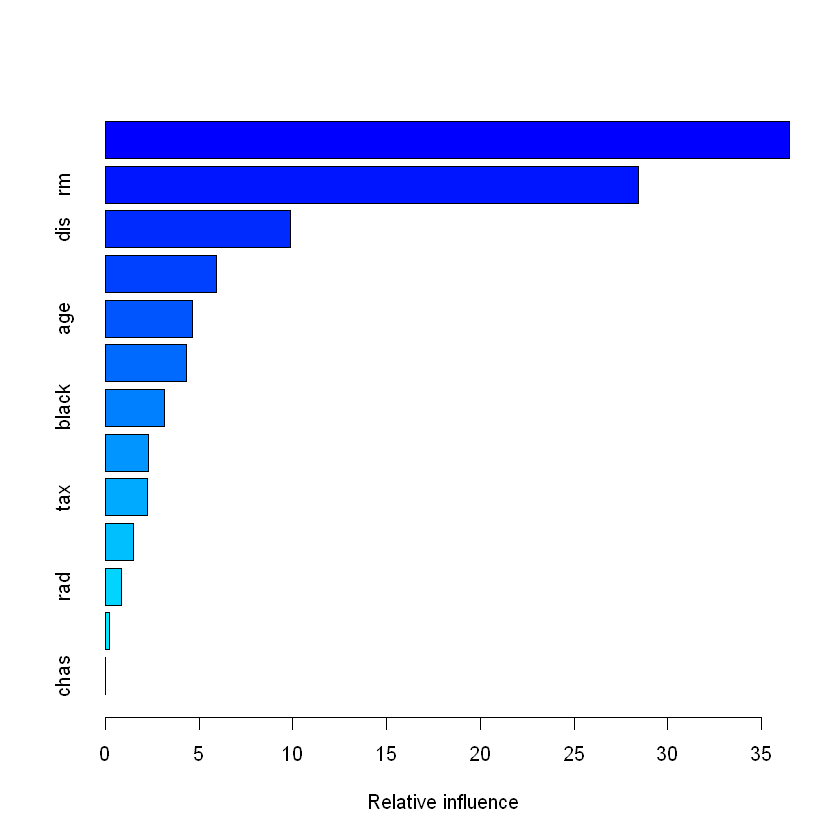

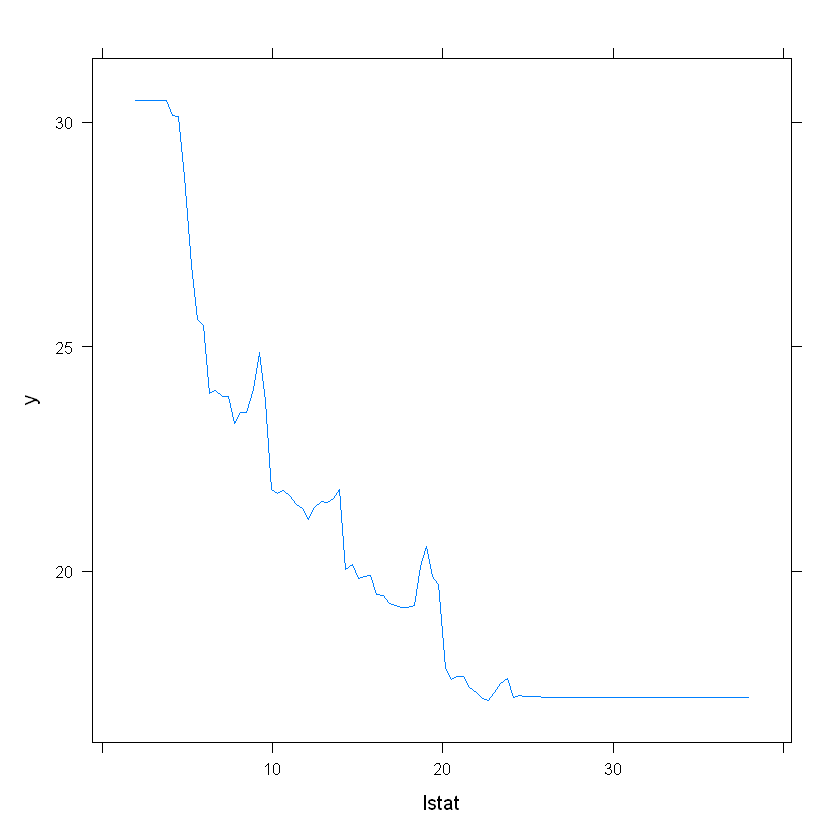

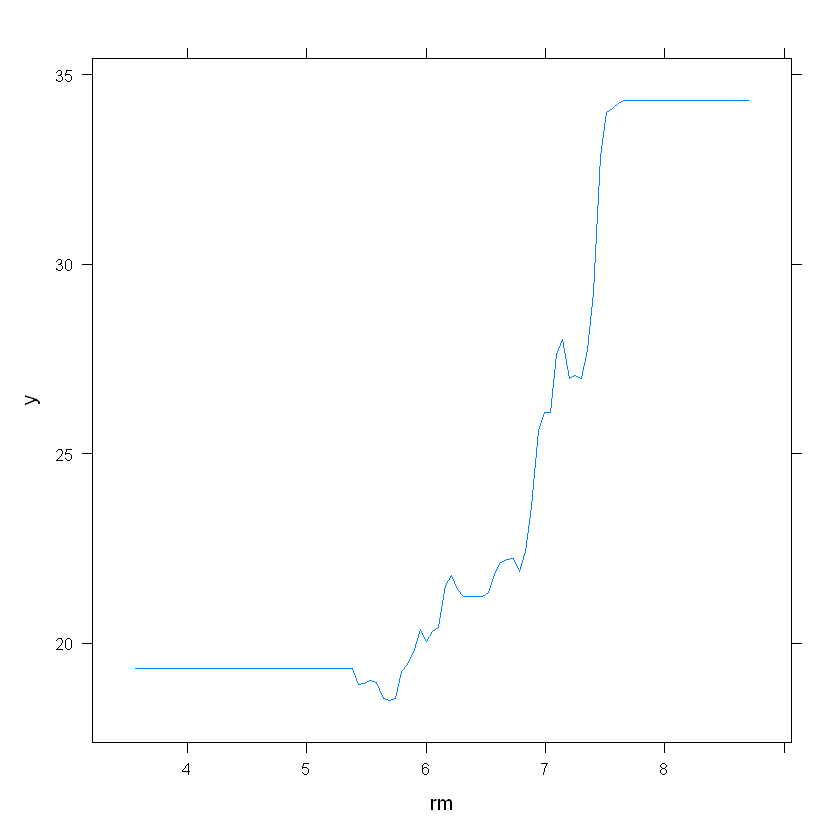

In [15]:
# gbm: Gradient Boosted Machines
if (!require(gbm)) {
    install.packages("gbm")
}
# GBM asks for the distribution, which is Gaussian, because we're doing
# squared error loss.
# We're going to ask gbm for 10k trees whcih sounds like a lot, but
# these are going to be shallow trees.
# interaction.depth is the number of splits, we only want 4 splits for shallow trees.
# shrinkage is how much we're going to shrink the trees back.
boost.boston <- gbm(medv ~ ., data = Boston[train, ], distribution = "gaussian", n.trees = 10000, shrinkage = 0.01, interaction.depth = 4)
# Gives a variable-importance plot.
# There's two important variables, the number of rooms and lstat which is the
# percentage of lower economic status people in the community.
summary(boost.boston)
# Plot shows us that the higher the proportion of the lower status people
# in the suburb, the lower the value of the house. Not a big surprise there.
plot(boost.boston, i = "lstat")
# Reverse relationship with the number of rooms in the house. As the number
# of rooms in the house increases, the price increases.
plot(boost.boston, i = "rm")


Let's make a prediction on the test set. With boosting, the number of trees is a
runing parameter, and if we have too many we can overfit. So we should use cross-validation
to select the number of trees. We will leave this as an exercise. Instead, we will compute
the test error as a function of the number of trees, and make a plot.


[1] 206 100

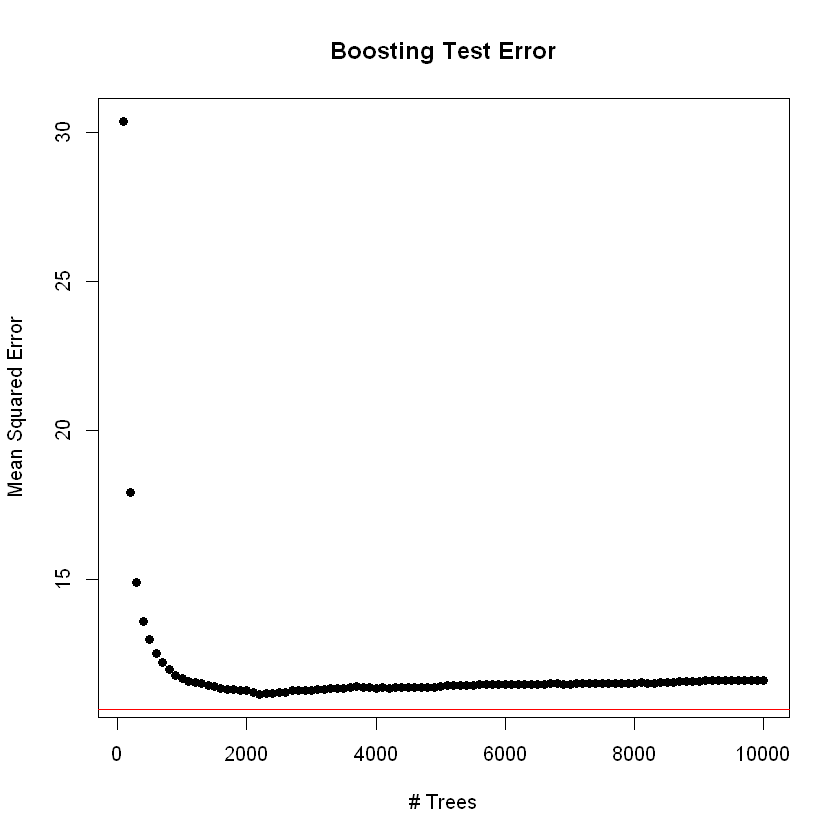

In [27]:
n.trees <- seq(from = 100, to = 10000, by = 100)
# Run prediciton on boost model.
predmat <- predict(boost.boston, newdata = Boston[-train, ], n.trees = n.trees)
# 206 test observations, 100 different predict vectors
# at those 100 different values of tree.
dim(predmat)
# predmat is a matrix and medv is a vector, so apply here just recycles the vector.
# a bit of trickery. So predmat - medv is actually a matrix of differences.
# and then we apply to these columns, the square differences of mean to compute the
# column-wise mean squared error.
berr <- with(Boston[-train, ], apply((predmat - medv)^2, 2, mean))
# Boosting error plot: pretty much drops down and drops down lower
# than the randomForest. This is as a function of the number of trees.
# And then it seems to level off, and it doesn't appear to be increasing.
# If you really ramped up the number of trees to a much bigger number,
# it would slowly start to increase. But this is evidence of the claim that
# boosting is reluctant to overfit.
plot(n.trees, berr, pch = 19, ylab = "Mean Squared Error", xlab = "# Trees", main = "Boosting Test Error")
# Include the best test error from the randomForest
abline(h = min(test.err), col = "red")
# We see that boosting actually got a reasonable amount below the
# test error for the randomForest.


Our experience is that boosting, especially if you're willing to go through the
tweaking and the tuning, will usually outperform randomForests. But randomForests
are really dead easy. They won't overfit. The only tuning parameter is the mtry.
But when I say they were won't overfit, by being increasing the number of trees
in randomForest, it won't overfit. It'll just, once it stabilizes, it's stabilized.
And adding more trees doesn't make much difference. With boosting, not the case.
You've got genuine tuning parameters, the number of trees, the shrinkage
parameter, and the depth. But both very powerful methods.
